<a href="https://colab.research.google.com/github/yuktha2005/FactoryGuard-AI/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving predictive_maintenance_dataset.csv to predictive_maintenance_dataset (2).csv


In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, classification_report

from xgboost import XGBClassifier

# 🔽 ADDED (for model serialization)
import joblib
import os


# =====================================
# 1. LOAD PROCESSED DATASET
# =====================================

processed_path = "predictive_maintenance_dataset (2).csv"
df = pd.read_csv(processed_path)

print("Dataset shape:", df.shape)


# =====================================
# 2. DEFINE FEATURES & TARGET
# =====================================

target_column = "label"

X = df.drop(columns=[target_column])
y = df[target_column]

# DROP NON-NUMERIC COLUMNS (timestamps, strings)
non_numeric_cols = X.select_dtypes(include=["object"]).columns
print("Dropping non-numeric columns:", list(non_numeric_cols))

X = X.drop(columns=non_numeric_cols)


# =====================================
# 3. TRAIN–TEST SPLIT
# =====================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# =====================================
# 4. RANDOM FOREST (BASELINE MODEL)
# =====================================

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print("\n===== RANDOM FOREST RESULTS ===жды")
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print(classification_report(y_test, rf_pred))


# =====================================
# 5. HANDLE CLASS IMBALANCE FOR XGBOOST
# =====================================

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


# =====================================
# 6. XGBOOST (HIGH-DIMENSIONAL MODEL)
# =====================================

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)


# =====================================
# 7. THRESHOLD-BASED PREDICTION
# =====================================

y_prob = xgb_model.predict_proba(X_test)[:, 1]

threshold = 0.3   # lower threshold → higher recall
xgb_pred = (y_prob >= threshold).astype(int)


# =====================================
# 8. XGBOOST EVALUATION
# =====================================

xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

print("\n===== XGBOOST RESULTS ===жды")
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)
print(classification_report(y_test, xgb_pred))


# =====================================
# 9. FINAL COMPARISON
# =====================================

print("\n===== FINAL COMPARISON ===жды")
print(f"Random Forest -> Recall: {rf_recall:.4f}, F1: {rf_f1:.4f}")
print(f"XGBoost       -> Recall: {xgb_recall:.4f}, F1: {xgb_f1:.4f}")


# =====================================
# 10. SAVE FINAL MODEL (FOR WEEK-4 API)
# =====================================

os.makedirs("models", exist_ok=True)

# Save XGBoost model with the name expected by the Flask app
joblib.dump(xgb_model, "models/factoryguard_xgb.pkl")

# Save feature column names for the Flask app
joblib.dump(X_train.columns.tolist(), "models/feature_columns.pkl")

print("\nFinal XGBoost model saved at: models/factoryguard_xgb.pkl")
print("Feature columns saved at: models/feature_columns.pkl")

Dataset shape: (1800, 10)
Dropping non-numeric columns: ['timestamp', 'machine_id']

===== RANDOM FOREST RESULTS ===жды
Recall: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00        40

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


===== XGBOOST RESULTS ===жды
Recall: 1.0
F1 Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00        40

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


===== FINAL COMPARISON ===жды
Random Forest -> Recall: 1.0000, F1: 1.0000
XGBoost       -> Recall: 1.0000, F1: 1.0000

Final XGBoost model save

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving predictive_maintenance_dataset.csv to predictive_maintenance_dataset (1).csv


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# =====================================
# 0. SETUP
# =====================================

os.makedirs("results/shap", exist_ok=True)
np.random.seed(42)

# =====================================
# 1. LOAD DATA
# =====================================

df = pd.read_csv("predictive_maintenance_dataset (1).csv")

TARGET = "label"

X = df.drop(columns=[TARGET])
y = df[TARGET]

X = X.select_dtypes(exclude=["object"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =====================================
# 2. TRAIN XGBOOST MODEL
# =====================================

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

# =====================================
# 3. SHAP EXPLAINER (MODEL-AGNOSTIC)
# =====================================

background = X_train.sample(100, random_state=42)

X_test_shap = X_test.sample(100, random_state=42)
y_test_shap = y_test.loc[X_test_shap.index]

explainer = shap.Explainer(
    model.predict_proba,
    background
)

shap_values = explainer(X_test_shap)

# =====================================
# 4. SHAP SUMMARY PLOT (GLOBAL)
# =====================================

plt.figure()
shap.summary_plot(
    shap_values[:, :, 1],
    X_test_shap,
    show=False
)
plt.title("SHAP Summary Plot – Failure Risk")
plt.savefig("results/shap/shap_summary.png", dpi=300, bbox_inches="tight")
plt.close()

# =====================================
# 5. SHAP FORCE PLOT (LOCAL – CORRECT)
# =====================================

failure_rows = y_test_shap[y_test_shap == 1]

if len(failure_rows) == 0:
    raise ValueError("No failure samples in SHAP subset")

row_index = failure_rows.index[0]
row_number = X_test_shap.index.get_loc(row_index)

base_value = shap_values.base_values[row_number, 1]
shap_row = shap_values[row_number, :, 1].values

shap.force_plot(
    base_value,
    shap_row,
    X_test_shap.iloc[row_number],
    matplotlib=True,
    show=False
)

plt.title("SHAP Force Plot – Individual Failure Prediction")
plt.savefig("results/shap/shap_force.png", dpi=300, bbox_inches="tight")
plt.close()

# =====================================
# 6. FEATURE IMPORTANCE TABLE
# =====================================

mean_abs_shap = np.abs(shap_values[:, :, 1].values).mean(axis=0)

importance_df = pd.DataFrame({
    "Feature": X_test_shap.columns,
    "Mean |SHAP Value|": mean_abs_shap
}).sort_values(by="Mean |SHAP Value|", ascending=False)

importance_df.to_csv(
    "results/shap/shap_feature_importance.csv",
    index=False
)

print("\nTop 10 Important Features:")
print(importance_df.head(10))

print("\n[Week-3 XAI completed successfully]")

Train shape: (1440, 7)
Test shape : (360, 7)


/tmp/ipython-input-692983823.py:78: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



Top 10 Important Features:
       Feature  Mean |SHAP Value|
2  temperature       8.754478e-02
0    vibration       5.578548e-02
3      current       3.495601e-02
1     acoustic       2.416045e-02
5        IMF_2       4.333081e-05
6        IMF_3       3.552183e-05
4        IMF_1       1.791102e-18

[Week-3 XAI completed successfully]


Displaying SHAP Summary Plot:


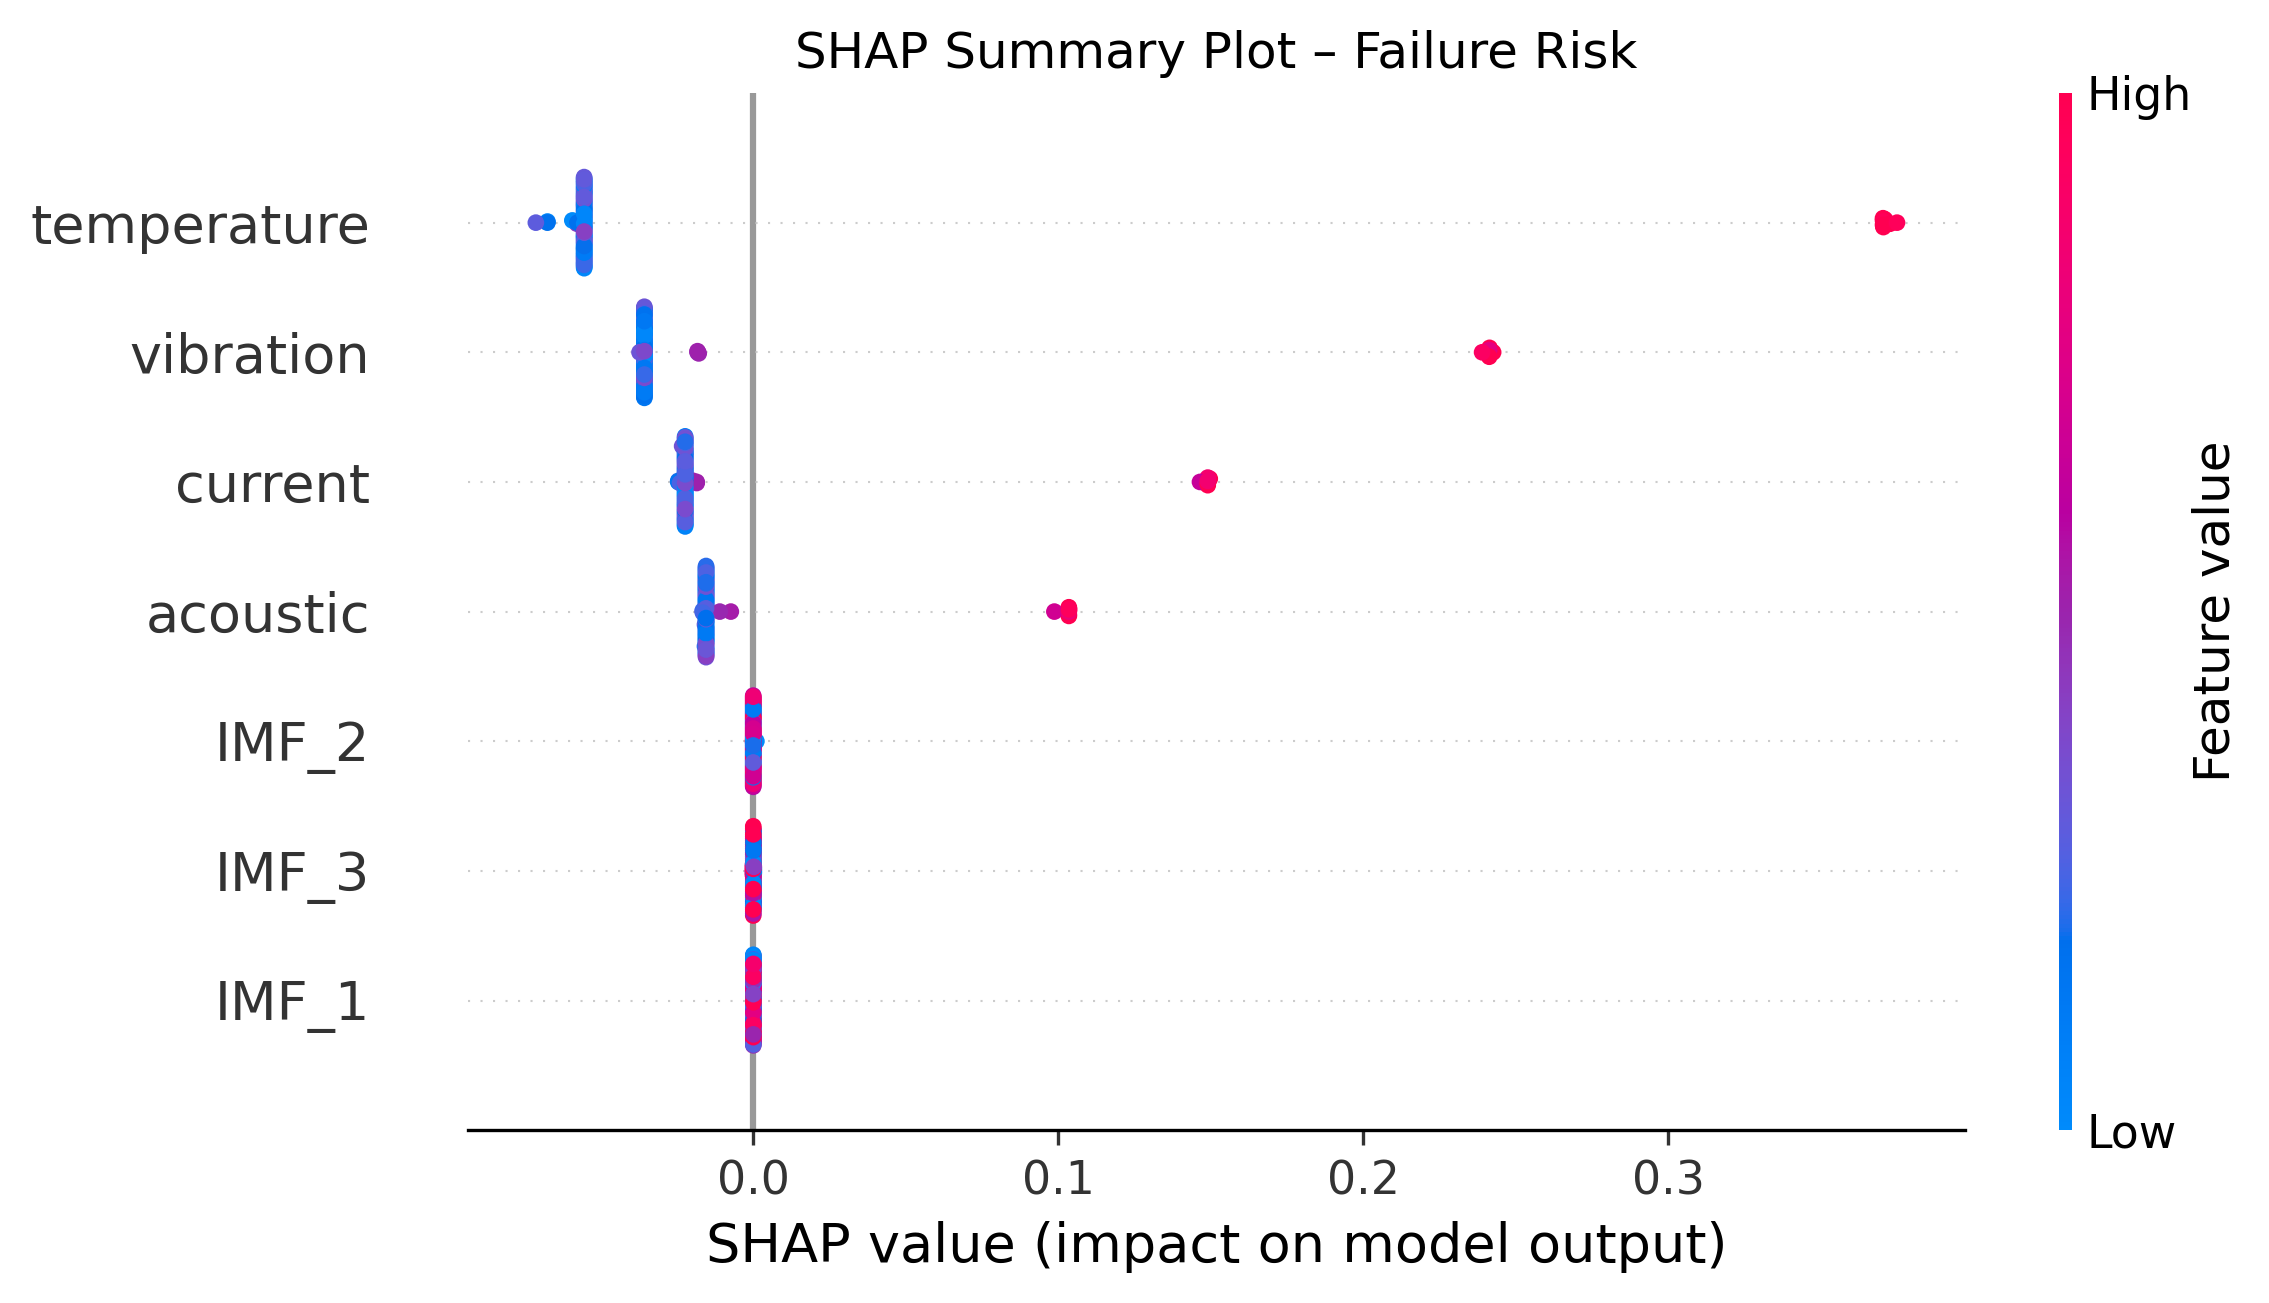

In [ ]:
from IPython.display import Image, display

print("Displaying SHAP Summary Plot:")
display(Image(filename="results/shap/shap_summary.png"))

Displaying SHAP Force Plot:


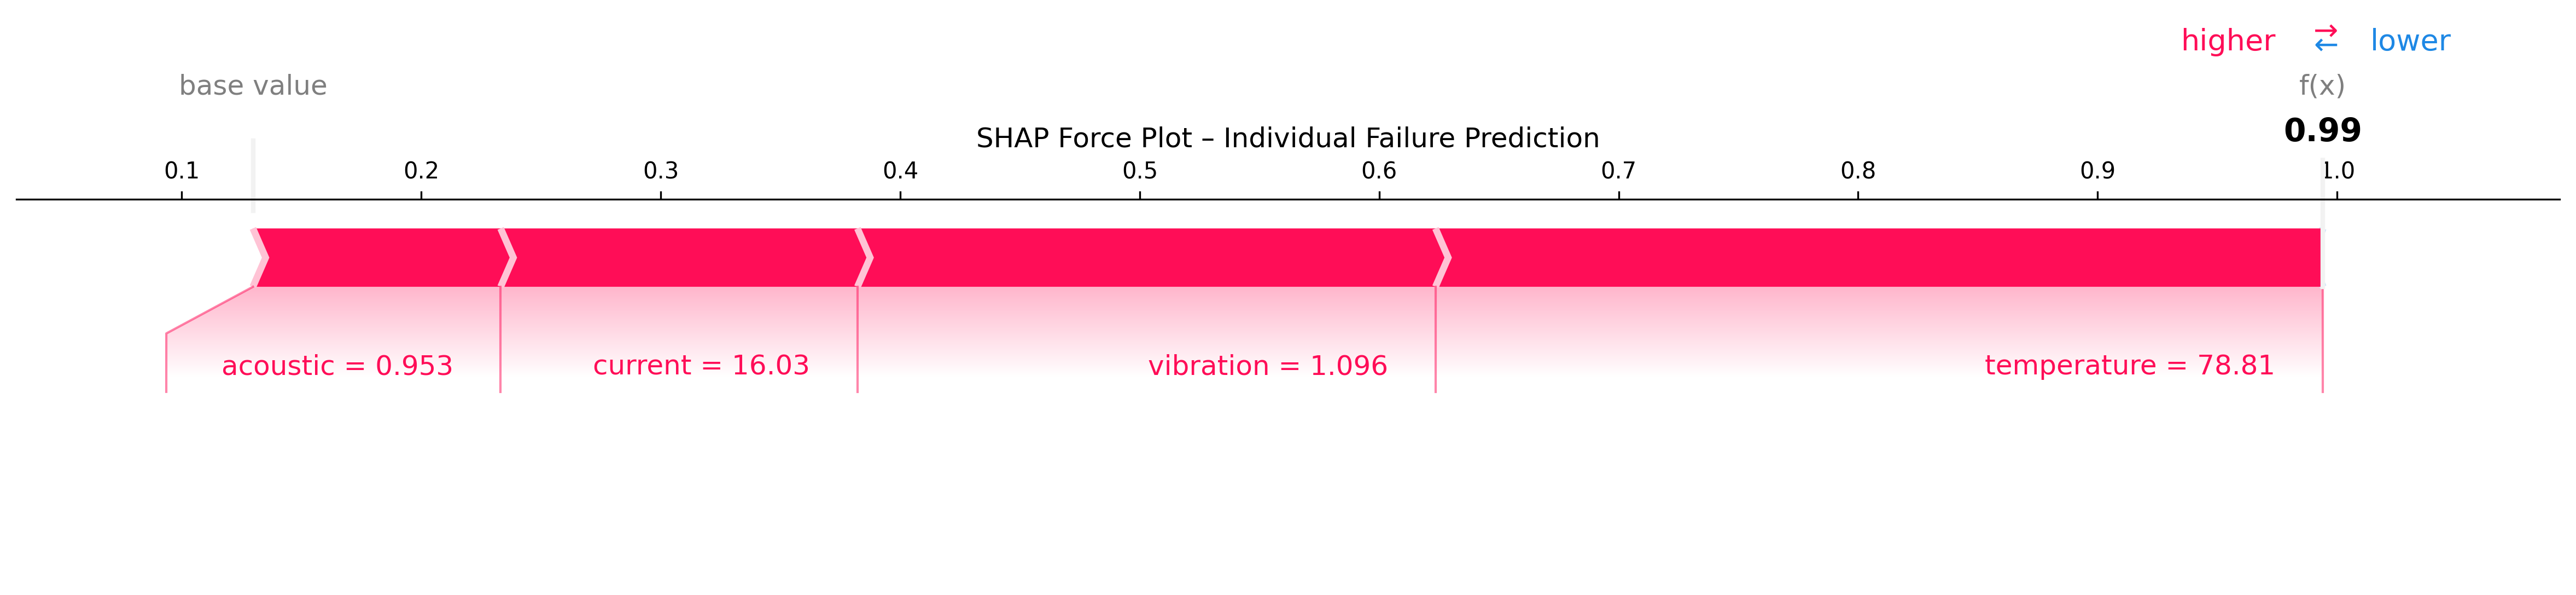

In [ ]:
from IPython.display import Image, display

print("Displaying SHAP Force Plot:")
display(Image(filename="results/shap/shap_force.png"))

In [ ]:
!pip install xgboost shap flask joblib pyngrok


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving predictive_maintenance_dataset.csv to predictive_maintenance_dataset (3).csv


In [ ]:
"""
Week 4 — Model Deployment (Model-as-a-Service)
Project : FactoryGuard AI
Goal    : Serve failure probability + SHAP explanation via REST API
Author  : Rohn Dhwan
"""

# =====================================
# 0. IMPORTS & SETUP
# =====================================

import json
import joblib
import numpy as np
import pandas as pd
import shap
from flask import Flask, request, jsonify

# =====================================
# 1. LOAD MODEL & METADATA
# =====================================

MODEL_PATH = "models/factoryguard_xgb.pkl"
FEATURE_PATH = "models/feature_columns.pkl"

model = joblib.load(MODEL_PATH)
feature_columns = joblib.load(FEATURE_PATH)

explainer = shap.TreeExplainer(model)

# =====================================
# 2. FLASK APP
# =====================================

app = Flask(__name__)

# =====================================
# 3. HEALTH CHECK
# =====================================

@app.route("/health", methods=["GET"])
def health():
    return jsonify({"status": "UP"}), 200

# =====================================
# 4. PREDICTION ENDPOINT
# =====================================

@app.route("/predict", methods=["POST"])
def predict():

    input_json = request.get_json()

    # --- Validation ---
    missing = [f for f in feature_columns if f not in input_json]
    if missing:
        return jsonify({
            "error": "Missing required features",
            "missing_features": missing
        }), 400

    # --- Create DataFrame ---
    input_df = pd.DataFrame([input_json])[feature_columns]

    # --- Prediction ---
    failure_prob = float(model.predict_proba(input_df)[0, 1])

    # --- SHAP Explanation ---
    shap_values = explainer(input_df)
    shap_contrib = shap_values.values[0, :, 1]

    shap_dict = dict(
        sorted(
            zip(feature_columns, shap_contrib),
            key=lambda x: abs(x[1]),
            reverse=True
        )[:5]
    )

    # --- Response ---
    return jsonify({
        "failure_probability": round(failure_prob, 4),
        "top_risk_factors": shap_dict
    })

# =====================================
# 5. ENTRY POINT
# =====================================

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
